In [ ]:
!pip -q install scikit-image

In [ ]:
import os, json
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.feature import local_binary_pattern

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score
)

import joblib

In [ ]:
BASE = "/content/drive/MyDrive/PCVK/fruit-clean"

TRAIN_DIR = f"{BASE}/Training"
TEST_DIR  = f"{BASE}/Test"

# Folder output artifacts di Drive
OUT_DIR = f"{BASE}/Output_Artifacts"
os.makedirs(OUT_DIR, exist_ok=True)

print("Train dir:", TRAIN_DIR)
print("Test dir :", TEST_DIR)
print("Out dir  :", OUT_DIR)


Train dir: /content/drive/MyDrive/PCVK/fruit-clean/Training
Test dir : /content/drive/MyDrive/PCVK/fruit-clean/Test
Out dir  : /content/drive/MyDrive/PCVK/fruit-clean/Output_Artifacts


In [ ]:
def list_classes(folder):
    classes = [d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))]
    classes = sorted(classes)
    return classes

train_classes = list_classes(TRAIN_DIR)
test_classes  = list_classes(TEST_DIR)

print("Jumlah kelas (train):", len(train_classes))
print("Jumlah kelas (test) :", len(test_classes))

# Safety check: harus sama
missing_in_test = sorted(set(train_classes) - set(test_classes))
missing_in_train = sorted(set(test_classes) - set(train_classes))

print("Missing in test :", missing_in_test)
print("Missing in train:", missing_in_train)

assert len(train_classes) == 25, "Train bukan 25 kelas. Cek foldernya."
assert train_classes == test_classes, "Kelas train & test tidak identik. Samakan dulu nama foldernya."


Jumlah kelas (train): 25
Jumlah kelas (test) : 25
Missing in test : []
Missing in train: []


In [ ]:
IMG_SIZE = (100, 100)

def preprocess_rgb(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, IMG_SIZE)
    img = img.astype("float32") / 255.0
    return img

def preprocess_gray(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, IMG_SIZE)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = gray.astype("float32") / 255.0
    return gray

def extract_color_histogram(rgb_img, bins=(8,8,8)):
    hsv = cv2.cvtColor((rgb_img * 255).astype("uint8"), cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0,1,2], None, bins, [0,180, 0,256, 0,256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def extract_lbp(gray_img, P=8, R=1):
    lbp = local_binary_pattern(gray_img, P, R, method="uniform")
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P+3), range=(0, P+2))
    hist = hist.astype("float32")
    hist /= (hist.sum() + 1e-6)
    return hist


In [ ]:
def load_features_from_folder(base_dir, class_names):
    X, y = [], []
    for cls in class_names:
        cls_dir = os.path.join(base_dir, cls)
        files = [f for f in os.listdir(cls_dir) if f.lower().endswith((".jpg",".jpeg",".png"))]

        for f in files:
            p = os.path.join(cls_dir, f)
            rgb = preprocess_rgb(p)
            gray = preprocess_gray(p)

            feat = np.hstack([
                extract_color_histogram(rgb),
                extract_lbp(gray)
            ])

            X.append(feat)
            y.append(cls)

    return np.array(X, dtype="float32"), np.array(y)


In [ ]:
X_TRAIN_PATH = os.path.join(OUT_DIR, "X_Training.npy")
y_TRAIN_PATH = os.path.join(OUT_DIR, "y_Training.npy")
X_TEST_PATH  = os.path.join(OUT_DIR, "X_Test.npy")
y_TEST_PATH  = os.path.join(OUT_DIR, "y_Test.npy")

USE_CACHE = all(os.path.exists(p) for p in [X_TRAIN_PATH, y_TRAIN_PATH, X_TEST_PATH, y_TEST_PATH])
print("USE_CACHE =", USE_CACHE)

if USE_CACHE:
    X_train = np.load(X_TRAIN_PATH)
    y_train = np.load(y_TRAIN_PATH, allow_pickle=True)
    X_test  = np.load(X_TEST_PATH)
    y_test  = np.load(y_TEST_PATH, allow_pickle=True)
else:
    X_train, y_train = load_features_from_folder(TRAIN_DIR, train_classes)
    X_test,  y_test  = load_features_from_folder(TEST_DIR,  train_classes)

    np.save(X_TRAIN_PATH, X_train)
    np.save(y_TRAIN_PATH, y_train)
    np.save(X_TEST_PATH,  X_test)
    np.save(y_TEST_PATH,  y_test)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test :", X_test.shape,  "y_test :", y_test.shape)


USE_CACHE = True
X_train: (23010, 1417) y_train: (23010,)
X_test : (7662, 1417) y_test : (7662,)


In [ ]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

# simpan class names
with open(os.path.join(OUT_DIR, "class_names.json"), "w") as f:
    json.dump(le.classes_.tolist(), f, indent=2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

joblib.dump(scaler, os.path.join(OUT_DIR, "scaler.pkl"))
print("Scaler saved.")


Scaler saved.


Sebelum PCA: (23010, 1417)
Sesudah PCA : (23010, 427)


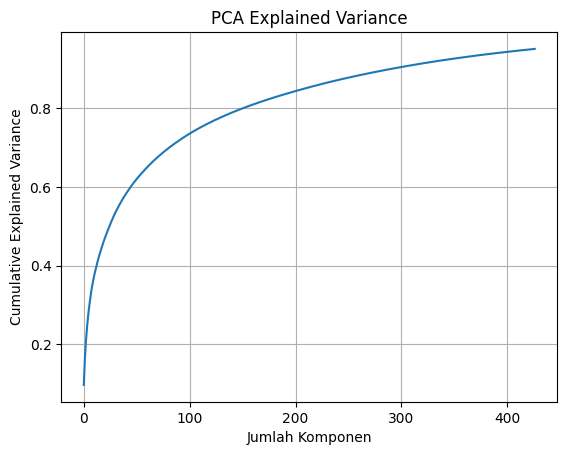

PCA saved.


In [ ]:
# kamu bisa ubah. 0.95 artinya jaga 95% informasi.
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print("Sebelum PCA:", X_train_scaled.shape)
print("Sesudah PCA :", X_train_pca.shape)

# plot cumulative explained variance
cum = np.cumsum(pca.explained_variance_ratio_)
plt.figure()
plt.plot(cum)
plt.xlabel("Jumlah Komponen")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid(True)
plt.show()

joblib.dump(pca, os.path.join(OUT_DIR, "pca.pkl"))
print("PCA saved.")

In [ ]:
param_grid = {
    "C": [1, 10],
    "gamma": ["scale", 0.01],
    "kernel": ["rbf"]
}

svm = SVC()

grid = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train_pca, y_train_enc)

print("Best params:", grid.best_params_)
print("Best CV acc :", grid.best_score_)

best_model = grid.best_estimator_
joblib.dump(best_model, os.path.join(OUT_DIR, "svm_fruit_model.pkl"))
print("Saved model.")


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV acc : 0.9781833985223816
Saved model.


In [ ]:
y_pred = best_model.predict(X_test_pca)

acc = accuracy_score(y_test_enc, y_pred)
prec = precision_score(y_test_enc, y_pred, average="weighted", zero_division=0)
rec = recall_score(y_test_enc, y_pred, average="weighted", zero_division=0)
f1 = f1_score(y_test_enc, y_pred, average="weighted", zero_division=0)

print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1       :", f1)

print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_, zero_division=0))


Accuracy : 0.9749412685982772
Precision: 0.9772692055256618
Recall   : 0.9749412685982772
F1       : 0.9740789062841838

Classification Report:
                      precision    recall  f1-score   support

               Beans       1.00      1.00      1.00        77
        Cactus Fruit       0.88      1.00      0.94       634
           Corn Husk       1.00      0.65      0.79       154
            Cucumber       0.98      1.00      0.99      1378
       Cucumber Ripe       1.00      1.00      1.00       286
            Eggplant       1.00      0.80      0.89       156
       Eggplant Long       1.00      0.99      0.99        80
              Pepino       1.00      1.00      1.00       166
        Pepper Green       1.00      0.94      0.97       148
       Pepper Orange       1.00      1.00      1.00       234
          Pepper Red       0.80      0.91      0.85       222
       Pepper Yellow       1.00      1.00      1.00       222
        Pitahaya Red       1.00      1.00      1.

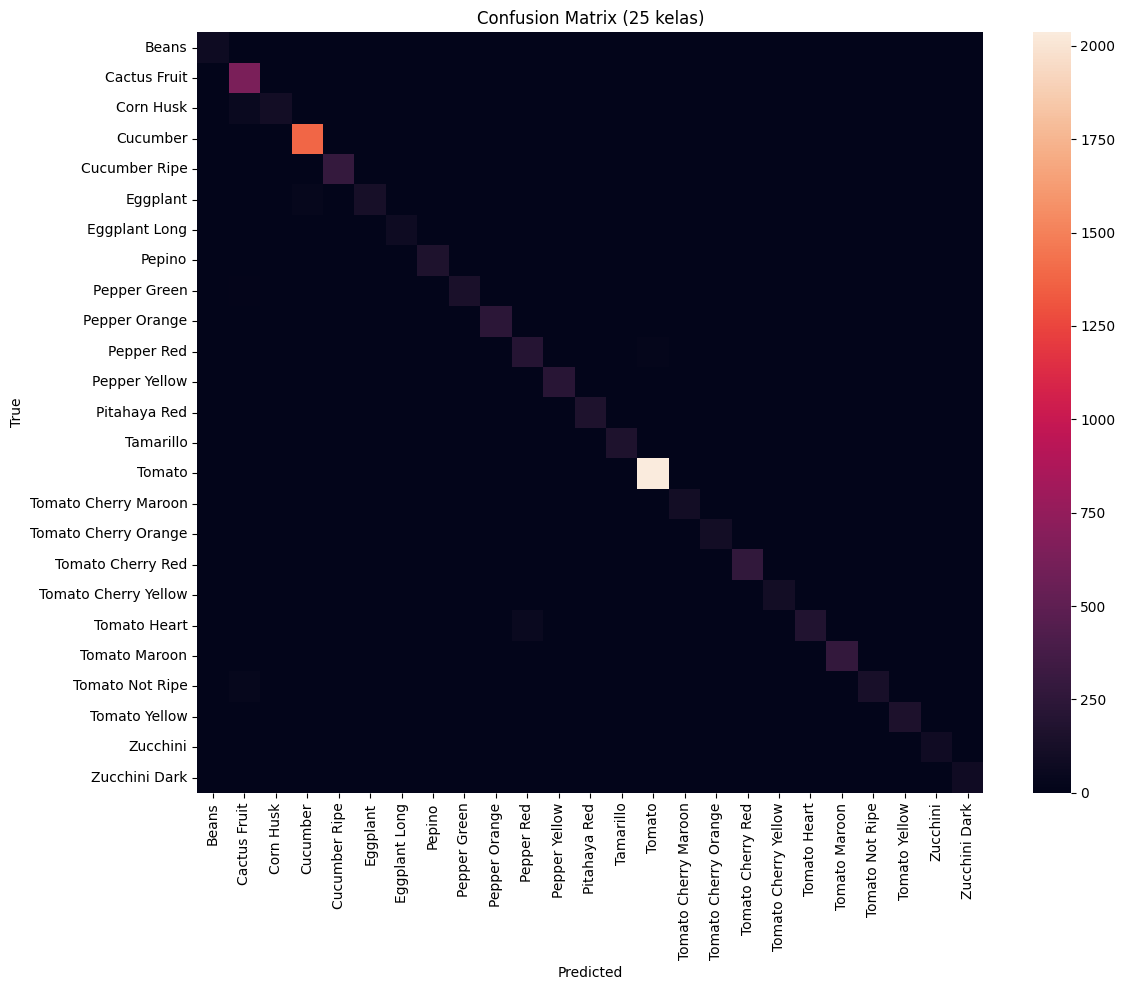

Saved evaluation_results.json


In [ ]:
cm = confusion_matrix(y_test_enc, y_pred)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (25 kelas)")
plt.tight_layout()
plt.show()

results = {
    "accuracy": float(acc),
    "precision_weighted": float(prec),
    "recall_weighted": float(rec),
    "f1_weighted": float(f1),
    "best_params": grid.best_params_,
    "best_cv_acc": float(grid.best_score_),
    "pca_components": int(X_train_pca.shape[1])
}

with open(os.path.join(OUT_DIR, "evaluation_results.json"), "w") as f:
    json.dump(results, f, indent=2)

print("Saved evaluation_results.json")
